Inspection of the entire CMC Human clinical data set and its subset that is relevant to our BSM study.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import synapseclient
import fwsel
import readVCF
import re

## Data set
### Import and general properties

In [2]:
syn = synapseclient.login()
wdir = '/big/results/bsm/2020-08-05-cmc-clinical'
cmc_clinical_syn = syn.get('syn2279441', downloadLocation=wdir, ifcollision='overwrite.local')
cmc_clinical = pd.read_csv(cmc_clinical_syn.path, index_col='Individual ID')

Welcome, Attila Jones!



In [3]:
samples = pd.read_csv('/big/results/bsm/2020-05-18-processed-samples/all_samples.csv')
individuals = list(set(samples['Individual ID']))
individuals.sort()
print(len(samples), 'samples from', len(individuals), 'individuals')

116 samples from 95 individuals


In [4]:
clin = cmc_clinical.loc[individuals, :]
clin.to_csv(wdir + '/all_samples_clinical.csv')

### Adding ancestry

In [5]:
clin['Individual ID'] = clin.index
clin = readVCF.add_ancestry(clin)
clin = clin.drop(columns='Individual ID')

### Variables with missing values

In [6]:
l = list()
for col in clin.columns:
    missing = len(clin) - len(clin[col].dropna())
    s = pd.Series([missing], index=[col])
    l.append(s)

ss = pd.concat(l).sort_values()
ss.loc[ss != 0]

Brain Weight (in grams)        1
EV.3                           9
EV.2                           9
EV.1                           9
Genotyping_Sample_ID           9
                              ..
MaritalStatus                 95
FormalinTissue                95
Toxicology Screen: Alcohol    95
Time of Death                 95
ECT                           95
Length: 64, dtype: int64

Impute the missing observation for Brain Weight with the sample mean 

In [7]:
clin.loc[np.isnan(clin['Brain Weight (in grams)']), 'Brain Weight (in grams)'] = clin['Brain Weight (in grams)'].mean()

Do the same for the ancestry data! 

In [8]:
EVs = ['EV.' + y for y in list('12345')]
clin[EVs] = clin[EVs].fillna(clin[EVs].mean())

### Filtering I

Now remove all columns with missing data

In [9]:
clin = clin.dropna(axis=1)
clin.columns

Index(['Institution', 'Reported Gender', 'Sex', 'Ethnicity', 'ageOfDeath',
       'Brain Weight (in grams)', 'PMI (in hours)', 'Dx', 'Year of Autopsy',
       'Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp',
       'Antidepress', 'Lithium', 'Tobacco', 'Alcohol', 'Illicitsub',
       'causeOfDeath', 'Hyperten', 'DiabetesInsDep', 'DiabetesNonInsDep',
       'EV.1', 'EV.2', 'EV.3', 'EV.4', 'EV.5'],
      dtype='object')

Inspect data types for remaining columns

In [10]:
clin = clin.rename(columns={'PMI (in hours)': 'PMI', 'Year of Autopsy': 'YearOfAutopsy', 'Reported Gender': 'ReportedGender', 'Brain Weight (in grams)': 'BrainWeight'})
clin.dtypes

Institution           object
ReportedGender        object
Sex                   object
Ethnicity             object
ageOfDeath           float64
BrainWeight          float64
PMI                  float64
Dx                    object
YearOfAutopsy        float64
Benzodiazepines      float64
Anticonvulsants      float64
AntipsychTyp         float64
AntipsychAtyp        float64
Antidepress          float64
Lithium              float64
Tobacco              float64
Alcohol              float64
Illicitsub           float64
causeOfDeath         float64
Hyperten             float64
DiabetesInsDep       float64
DiabetesNonInsDep    float64
EV.1                 float64
EV.2                 float64
EV.3                 float64
EV.4                 float64
EV.5                 float64
dtype: object

Adjust data types

In [11]:
l = [clin.loc[:, :'Ethnicity'].astype('category'),
pd.DataFrame({'Dx': [np.int(y == 'SCZ') for y in clin['Dx']]}, index=clin.index),
clin.loc[:, 'Benzodiazepines':'DiabetesNonInsDep'].astype('int').astype('category'),
clin.loc[:, EVs]]
clin = pd.concat(l, axis=1)

### Filtering II

It turned out from an email communication with Jessica Johnson that there are missing data labeled with `-1`.  Let's filter the data according to this! 

In [12]:
for col in clin.loc[:, 'Benzodiazepines':].columns:
    s = clin.groupby(col).size()
    if -1 in set(s.index):
        print(s.loc[-1], 'missing in', col)

31 missing in Tobacco
1 missing in Alcohol
1 missing in causeOfDeath
10 missing in Hyperten
10 missing in DiabetesInsDep
10 missing in DiabetesNonInsDep


Only one point is missing for both Alcohol and causeOfDeath.  2020-08-07-cleaning-data shows that Alcohol is colinear with Ethnicity so it should be dropped. Thus causeOfDeath may be imputed and kept while the rest of the variables be dropped.

In [13]:
clin = clin.drop(columns=['Tobacco', 'Alcohol', 'Hyperten', 'DiabetesInsDep', 'DiabetesNonInsDep'])

Impute causeOfDeath

In [14]:
def replaceWithMode(col='Alcohol', clin=clin):
    '''Returns the mode i.e the most frequent category'''
    df = clin.groupby(col).size()
    d = dict(zip(list(df), df.index))
    mode = d[df.max()]
    s = clin[col]
    s = pd.Series([(lambda y: mode if y == -1 else y)(x) for x in s], index=clin.index, dtype='category')
    return(s)

clin['causeOfDeath'] = replaceWithMode(col='causeOfDeath')

### Further filtering to avoid colinearity

In [15]:
clin.columns

Index(['Institution', 'ReportedGender', 'Sex', 'Ethnicity', 'Dx',
       'Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp',
       'Antidepress', 'Lithium', 'Illicitsub', 'causeOfDeath', 'EV.1', 'EV.2',
       'EV.3', 'EV.4', 'EV.5'],
      dtype='object')

#### ReportedGender and Sex

One of the individuals was a schizophrenic male with Klinefelter syndrome.

In [16]:
clin.groupby(['ReportedGender', 'Sex', 'Dx']).size()

ReportedGender  Sex  Dx
Female          XX   0      9
                     1     25
                XXY  0      0
                     1      0
                XY   0      0
                     1      0
Male            XX   0      0
                     1      0
                XXY  0      0
                     1      1
                XY   0     19
                     1     41
dtype: int64

In [17]:
clin.loc[clin['Sex'] == 'XXY', ['ReportedGender', 'Sex']]

,ReportedGender,Sex
Individual ID,,
CMC_MSSM_213,Male,XXY


Note that there are no transgender individuals with canonical XX or XY chromosomes. It is simpler to keep ReportedGender and drop Sex because the latter is a three level factor whose third level, XXY, occurs only in one individual.

In [18]:
clin = clin.drop(columns='Sex') # this is essentially the same as "Sex" 

### Prettify column names

In [19]:
clin = clin.rename(lambda y: re.sub('\.', '_', y), axis='columns')
#clin = clin.reindex(columns=[re.sub('\.', '_', y) for y in clin.columns])

## The cleaned data set

In [20]:
clin

,Institution,ReportedGender,Ethnicity,Dx,Benzodiazepines,Anticonvulsants,AntipsychTyp,AntipsychAtyp,Antidepress,Lithium,Illicitsub,causeOfDeath,EV_1,EV_2,EV_3,EV_4,EV_5
Individual ID,,,,,,,,,,,,,,,,,
CMC_MSSM_027,MSSM,Male,Caucasian,1,0,0,0,0,0,0,0,1,0.019061,-0.043151,0.005808,0.131348,-0.019458
CMC_MSSM_033,MSSM,Female,African-American,0,0,0,0,0,0,0,0,1,-0.082774,0.000918,0.019960,-0.004903,-0.022186
CMC_MSSM_055,MSSM,Male,Caucasian,0,0,0,0,0,0,0,0,1,0.020298,0.018617,-0.001543,-0.010232,0.002140
CMC_MSSM_056,MSSM,Female,Caucasian,0,0,0,0,0,0,0,0,1,0.020853,0.030543,-0.006878,-0.011283,0.009727
CMC_MSSM_063,MSSM,Male,Caucasian,0,0,0,0,0,0,0,0,5,0.020810,-0.010395,0.001832,0.038164,-0.018054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC_PITT_098,Pitt,Male,Caucasian,0,0,0,0,0,0,0,0,1,0.021925,0.017359,0.001280,0.002445,0.003736
CMC_PITT_101,Pitt,Male,Caucasian,0,0,0,0,0,0,0,0,1,0.020204,-0.004967,-0.001258,0.041604,-0.004473
CMC_PITT_113,Pitt,Male,Caucasian,0,0,0,0,0,0,0,0,1,0.020509,0.025007,-0.001910,-0.031377,0.030459


## Modeling
### Forward selection

I used [this implementation](https://planspace.org/20150423-forward_selection_with_statsmodels/) of forward variable selection.  In this implementation the adjusted R-squared statistic was the score that was maximized as the algorithm progressed. 

In [21]:
best = fwsel.forward_selected(clin, 'Dx')

The results below show that typical and atypical antipsychotics have the most significant "effect" on schizophrenia 

In [22]:
best.model.formula

'Dx ~ AntipsychAtyp + AntipsychTyp + EV_3 + Institution + Benzodiazepines + EV_5 + EV_4 + EV_2 + Anticonvulsants + 1'

In [23]:
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     6.657
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           3.74e-07
Time:                        19:24:41   Log-Likelihood:                -34.843
No. Observations:                  95   AIC:                             89.69
Df Residuals:                      85   BIC:                             115.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6175      0.052     11.772      0.000       0.513       0.722
AntipsychAtyp[T.1]       0.3997      0.095      4.214      0.000       0.211       0.588
AntipsychTyp[T.1]        0.4165      0.107      3.903      0.000       0.204       0.629
Institution[T.Pitt]     -0.3230      0.103     -3.147      0.002      -0.527      -0.119
Benzodiazepines[T.1]    -0.2731      0.112     -2.433      0.017      -0.496      -0.050
Anticonvulsants[T.1]     0.1469      0.135      1.091      0.279      -0.121       0.415
EV_3                     3.1819      0.937      3.395      0.001       1.318       5.046
EV_5                    -1.8811      1.348     -1.395      0.167      -4.561       0.799
EV_4                     1.2118      1.002      1.210      0.230      -0.780       3.203
EV_2                     1.3129      1.141      1.151      0.253      -0.956       3.582
==============================================================================
Omnibus:                        9.145   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                4.645
Skew:                          -0.326   Prob(JB):                       0.0980
Kurtosis:                       2.134   Cond. No.                         40.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Antipsychotics

The following summary shows that out of 67 schizophrenic individuals 28 did not take any antipsychotics.

In [24]:
clin.groupby(['Dx', 'AntipsychTyp', 'AntipsychAtyp']).size()

Dx  AntipsychTyp  AntipsychAtyp
0   0             0                26
                  1                 2
    1             0                 0
                  1                 0
1   0             0                28
                  1                22
    1             0                11
                  1                 6
dtype: int64

### Fit diagnostics

Atypical antipsychothics `AntipsychAtyp` had the most significant effect on disease status `Dx`.  Below are regression plots for this variable that show residuals as well as regression coefficients (slopes of solid straight lines in lower plots).

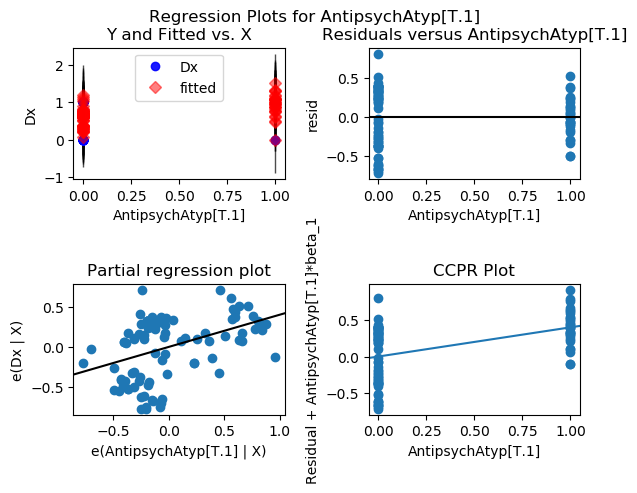

In [25]:
%matplotlib tk
sm.graphics.plot_regress_exog(best, 'AntipsychAtyp[T.1]')

### What about Ethnicity?

To address this question we exclude EV_3 and repeat the forward variable selection

In [26]:
best1 = fwsel.forward_selected(clin.drop(columns=['EV_3']), 'Dx')

In [27]:
best1.model.formula

'Dx ~ AntipsychAtyp + AntipsychTyp + Antidepress + Ethnicity + Institution + Benzodiazepines + EV_4 + 1'

Recall the previous formula

In [28]:
best.model.formula

'Dx ~ AntipsychAtyp + AntipsychTyp + EV_3 + Institution + Benzodiazepines + EV_5 + EV_4 + EV_2 + Anticonvulsants + 1'

Comparing the new `best1` to the previous `best` we see that Ethinicity has been selected in `best1` instead of EV_5 and EV_2.  EV_4 is still selected in `best1`.

In [29]:
best1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     6.509
Date:                Wed, 12 Aug 2020   Prob (F-statistic):           1.32e-06
Time:                        19:24:43   Log-Likelihood:                -37.696
No. Observations:                  95   AIC:                             93.39
Df Residuals:                      86   BIC:                             116.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.7041      0.109      6.481      0.000       0.488       0.920
AntipsychAtyp[T.1]         0.4079      0.088      4.628      0.000       0.233       0.583
AntipsychTyp[T.1]          0.4093      0.109      3.748      0.000       0.192       0.626
Antidepress[T.1]          -0.1119      0.110     -1.013      0.314      -0.331       0.108
Ethnicity[T.Caucasian]    -0.0946      0.110     -0.859      0.393      -0.314       0.124
Ethnicity[T.Hispanic]     -0.8651      0.292     -2.967      0.004      -1.445      -0.285
Institution[T.Pitt]       -0.2579      0.100     -2.579      0.012      -0.457      -0.059
Benzodiazepines[T.1]      -0.1893      0.118     -1.604      0.112      -0.424       0.045
EV_4                       1.3811      1.031      1.339      0.184      -0.669       3.432
==============================================================================
Omnibus:                       14.218   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.704
Skew:                          -0.439   Prob(JB):                       0.0350
Kurtosis:                       2.040   Cond. No.                         37.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary shows that including EV_3 is beneficial for fit (R-squared, Adj. R-squared, AIC, BIC) although the effect is not enormous.

## Conclusions

* Much of the CMC clinical data is missing.  Filtering removed most variables leaving about a dozen, some of which had one missing valueh, which were imputed using the sample mean (or mode for categorical variables)
* Reported Gender and Sex are nearly identical.  Sex is a three level factor: XX, XY and XXY. The third level, XXY, occurs in only one individual, a schizophrenic male with Klinefelter syndrome.  To avoid colinearity between these two variables one of them needs to be removed.  Removing Sex leaves the simpler (two level) Reported Gender in the data set.
* The remaining 12 variables were split to 1 response (`Dx`) and 11 explanatory variables.  8/11 explanatory variables were selected with a forward strategy using normal linear models and adjusted R-squared as score.
* Among the 8 selected explanatory variables only AntipsychAtyp, AntipsychAtyp, Alcohol and Ancestry EV.3 (or Ethinicity if EV.3 has been omitted) had significant ($p \le 0.01$) "effect" on disease status.  Not quite significant effects were displayed by Institution and Gender.
* AntipsychAtyp, AntipsychAtyp might be assumed to be an *a posteriori* conditions relative to the onset of schizophrenia.  That assumption means they do not carry risk for schizophrenia.  On the other hand, Ancestry (Ethinicity) is clearly an *a priori* condition and as the regression coefficient's t-statistic suggests being African American carries risk relative to Hispanic individuals.
* Thus *a posteriori* explanatory variables may or may not be included in further analyses. 
    * If they *are* included they improve fit
    * If they are *not* included they might confound inference.  Despite that excluding all clinical variables (except individual ID) is beneficial because ordinary least squares (OLS) can be used instead of generalized ones (GLS).

In [30]:
%connect_info

{
  "shell_port": 51585,
  "iopub_port": 41747,
  "stdin_port": 58689,
  "control_port": 53391,
  "hb_port": 41059,
  "ip": "127.0.0.1",
  "key": "7db0785a-f18061a9c8da1492a4345949",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-68b44792-5c18-46d5-971c-f067d527ac84.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
